<h1>Betfair market data investigation and automated trading app development</h1>

<p>import pandas</p>

The purpose of the investigation is to attempt to analyse betfair market data in order to attempt to identify betting patterns which might facilitate the creation of a profitable automated trading algorythm.

The investigatin and development will be undertaken in 4 phases:<br>
1)the market data analysis<br>
2)developing an algorythm<br>
3)integrating the betfair API<br>
4)testing the algorythm with streams generated from downloaded market data.<br>

<h1>Phase 1, Market Data Analysis</h1>

In [1]:
import pandas as pd
from pandas import Series
import json
import matplotlib.pyplot as plt
import numpy as np

<p>The betfair historical data files are are published in json formatt.  Each file consists of thousands of json objects.  <p>

<p> Python has a library for working with json objects which includes methods for encoding and decoding json objects.  My file is string object so json.loads will be able to convert this string into a python object which will allow mr to access and manipulate the data.  Json.loads however can only convert 1 json object at a time and the string contains thousands of objects so I will need a way of iterating of the string file and converting each object in turn.  And adding it to a list</p>

Here is a link to the JSON library documentation and the json.loads method.

https://docs.python.org/3/library/json.html

Here is a link to an implementation I found on the internet!

https://pynative.com/python-parse-multiple-json-objects-from-file/#:~:text=JSONDecodeError%3A%20Extra%20data%20error%20.,handle%20a%20single%20JSON%20object.&text=The%20file%20is%20invalid%20if%20it%20contains%20more%20than%20one%20JSON%20object.

In [2]:
marketData = []
print("Reading JSON string")
with open('data.txt') as f:
    for jsonObj in f:
        marketUpdate = json.loads(jsonObj)
        marketData.append(marketUpdate)
print("Done!")

Reading JSON string
Done!


The method was successfull.  below is what the maketData list now looks like.  The JSON structure is clearly visisble.

In [3]:
marketData

[{'op': 'mcm',
  'clk': '824571206',
  'pt': 1578127437668,
  'mc': [{'id': '1.167019301',
    'marketDefinition': {'bspMarket': True,
     'turnInPlayEnabled': True,
     'persistenceEnabled': True,
     'marketBaseRate': 5.0,
     'eventId': '29640618',
     'eventTypeId': '7',
     'numberOfWinners': 1,
     'bettingType': 'ODDS',
     'marketType': 'WIN',
     'marketTime': '2020-01-05T12:30:00.000Z',
     'suspendTime': '2020-01-05T12:30:00.000Z',
     'bspReconciled': False,
     'complete': True,
     'inPlay': False,
     'crossMatching': False,
     'runnersVoidable': False,
     'numberOfActiveRunners': 7,
     'betDelay': 0,
     'status': 'OPEN',
     'runners': [{'adjustmentFactor': 41.88,
       'status': 'ACTIVE',
       'sortPriority': 1,
       'id': 12146123,
       'name': 'Zapper Cass'},
      {'adjustmentFactor': 13.62,
       'status': 'ACTIVE',
       'sortPriority': 2,
       'id': 10108396,
       'name': 'George Thomas'},
      {'adjustmentFactor': 12.64,
    

In [4]:
type(marketData)

list

Most of the data in the JSON objects are nested dicts.  I can easily extract data from the 1st level keys like in the example below.

Excellent videos explaining how to access data in nested JSON files.
https://www.youtube.com/watch?v=oQfNYqz8pLs

no rc field on second line of data.txt.  investigate how to handle missing keys.  need to find a way to skip.

In [5]:
marketD = {}
type(marketD)

dict

output dict needs to look something like this:

"{"change":[
            {"time":"pt",
            "data": [
                    {
                    "id":rid,
                    "ltp":ltp}
                    ]
             }
             ]
 }
 
 
 
 or maybe try to find a way to add driectly to a dataframe by creating a dict like this:
 
 {"pt":[],"id":[],"ltp":[]}

In [6]:
def getMarketData():
    timeList = []
    ridList = []
    ltpList = []
    for data in marketData:
        time = data['pt']
        market_change = data['mc']
        for change in market_change:
            key = 'rc'
            if key in change:
                rc_list = change['rc']
                for prices in rc_list:
                    rid = prices['id']
                    ltp = prices['ltp']
                    timeList.append(time)
                    ridList.append(rid)
                    ltpList.append(ltp)
    marketD['pt'] = timeList
    marketD['id'] = ridList
    marketD['ltp'] = ltpList
    marketdf = pd.DataFrame.from_dict(marketD)
    return marketdf


            

In [7]:
getMarketData()

,pt,id,ltp
0,1578127437668,14971907,0.00
1,1578127437668,19186442,0.00
2,1578127437668,12146123,0.00
3,1578127437668,10108396,0.00
4,1578127437668,21179785,0.00
...,...,...,...
31384,1578227525355,12146123,1.01
31385,1578227525355,10108396,1000.00
31386,1578227525355,21179785,1000.00
31387,1578227525355,13202265,1000.00


So i now have a function which can retreive data from the nested JSON files. and ouput a dataframe<br>
<br>
TO DO:<br>
    write function getFrontRun() to populate a list of runners and id the front runner<br>
    write function getTime() to decode the time data and isolate the section of greatest market activity (15mins before the off)<br>
    Adapt getMarketData() to accept args passed by getFrontRun() & getTime()<br>
    Experiment with analysis of data and attempt to highlight patterns in the market.<br>
    write function using method above for reading files from txt.<br>
    Investigate how to read files in batches and pass them to getMarketData().  Useful link https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory<br>
    analyse each marketdata for each race in a way that makes it possible to compare betting patterns and summarise data.<br>

<h2>ID the front runner</h2>

I'll start by copying the getMarketData function and edit it to return the runner id of the runner with "sortPriority":1

In [8]:
def getFrontRun():
    for data in marketData:
        market_change = data['mc']
        for mDef in market_change:
            key = 'marketDefinition'
            if key in mDef:
                mDefList = mDef['marketDefinition']
                runnersList = mDefList['runners']
                for runner in runnersList:
                    if runner['sortPriority'] == 1:
                        runnerId = runner['id']
                        return runnerId
            
    


In [9]:
getFrontRun()

12146123

Initial implementation did'nt work I had to break it down into parts, and when each part is working I'll put it back together.  Now all good.

<h2> getTime() funtion</h2>

ms since epoch is based on UTC time which is the same as GMT.  BST however is 1 hour ahead of UTC in summer need to take this into account with the final implementation however for this data set which is from janury it is not important.

In [10]:
from datetime import datetime
from datetime import timedelta

1st I'll need to access the "marketTime" attribute from the JSON file.  I will be focusing on the 20 mins prior to the "maketTime" value as this will be when market activity is at its peak before it goes in play.  The plan is all trading will commence within this 20 minute window.  I will calculoate a start time ("marketTime - 20mins).  I will then drop any data from the data frame outside of this window and focus my analysis on the remaining data.

I have to slice the Z off the end so that i can convert to a datetime object.

time string object will need to be converted into a dateTime object and the into ms since epoch. <br><br>Then start time = time  - (20 x 60 x 60 x 1000)

In [11]:
def getOffTime():
    for data in marketData:
        market_change = data['mc']
        for mDef in market_change:
            key = 'marketDefinition'
            if key in mDef:
                mDefList = mDef['marketDefinition']
                time = mDefList['marketTime']
    time = time[:-1]
    date_time_obj = datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.%f')
    endTime = date_time_obj.timestamp()*1000
    return endTime

and now to calculate the start time

In [12]:
def getStartTime(offTime):
    startTime = offTime - (20*60*1000)
    return startTime

In [28]:
def getMarketSliceById(runner, startTime, offTime):
    timeList = []
    ridList = []
    ltpList = []
    tvList = []
    tickList = []
    tickRun = []
    segmentList = []
    for data in marketData:
        time = data['pt']
        market_change = data['mc']
        if time < offTime and time >startTime:
            for change in market_change:
                key = 'rc'
                if key in change:
                    rc_list = change['rc']
                    for prices in rc_list:
                        rid = prices['id']
                        ltp = prices['ltp']
                        tv = prices['tv']
                        if runner == rid and ltp != 0:
                            countDown = (offTime / 60000) - (time / 60000)
                            timeList.append(countDown)
                            ridList.append(rid)
                            ltpList.append(ltp)
                            tvList.append(tv)
                            
    ltpcomp1 = ltpList.copy()
    del ltpcomp1[0]
    ltpcomp2 = ltpList.copy()
    ltpcomp2.pop()
    for a,b in zip(ltpcomp2, ltpcomp1):
        if a < b:
            tick = 1
            tickList.append(tick)
        elif a > b:
            tick = -1
            tickList.append(tick)
        else:
            tick = 0
            tickList.append(tick)
    
    counter = 0
    for i in tickList:
        if i == 1:
            counter = counter + 1
            tickRun.append(counter)
        elif i == -1:
            counter = counter - 1
            tickRun.append(counter)
        else:
            tickRun.append(counter)
    
    tickList.append(0) #add 0 to end of each list so all lists are equal length
    tickRun.append(0)
    
    #add a check to ensure all the lists are the same length for the data frame
    timeListLen = len(timeList)
    print('Time List length = ')
    print(timeListLen)
    ridListLen = len(ridList)
    print('Rid List length = ') 
    print(ridListLen)
    ltpListLen = len(ltpList)
    print('ltp List length = ') 
    print(ltpListLen)
    tickListLen = len(tickList)
    print('Tick List length = ') 
    print(tickListLen)
    tickRunListLen = len(tickRun)
    print('Tick Run List length = ') 
    print(tickRunListLen)
    tvListLen = len(tvList)
    print('Tv List length = ') 
    print (tvListLen)
    
    #populate segmentList
    
    for t in timeList:
        if t < 4:
            segmentList.append(1)
        elif t >= 4 and t < 8:
            segmentList.append(2)
        elif t >= 8 and t < 12:
            segmentList.append(3)
        elif t >= 12 and t < 16:
            segmentList.append(4)
        else:
            segmentList.append(5)
    
    print('Creating dictionary')
    marketD = {}
    print('populating dictionary!')
    marketD['Runner Id'] = ridList
    marketD['Segment'] = segmentList
    marketD['Countdown'] = timeList
    marketD['ltp'] = ltpList
    marketD['Tick'] = tickList
    marketD['Tick run'] = tickRun
    marketD['tv'] = tvList
    print('creating data frame!')
    marketdf = pd.DataFrame.from_dict(marketD)
    return marketdf


In [29]:
def getMarketSlice():
    offTime = getOffTime()
    startTime = getStartTime(offTime)
    marketLeader = getFrontRun()
    marketSlice = getMarketSliceById(marketLeader, startTime, offTime)
    return marketSlice

In [30]:
market_slice_df = getMarketSlice()
market_slice_df

Time List length = 
1102
Rid List length = 
1102
ltp List length = 
1102
Tick List length = 
1102
Tick Run List length = 
1102
Tv List length = 
1102
Creating dictionary
populating dictionary!
creating data frame!


,Runner Id,Segment,Countdown,ltp,Tick,Tick run,tv
0,12146123,5,19.993950,2.38,0,0,72934.66
1,12146123,5,19.976817,2.38,0,0,72934.66
2,12146123,5,19.960567,2.38,0,0,72934.66
3,12146123,5,19.943667,2.38,-1,-1,72934.66
4,12146123,5,19.926683,2.36,1,0,72938.51
...,...,...,...,...,...,...,...
1097,12146123,1,0.076100,2.30,-1,-9,256180.60
1098,12146123,1,0.059800,2.28,-1,-10,257048.06
1099,12146123,1,0.043050,2.26,0,-10,257117.30
1100,12146123,1,0.026667,2.26,0,-10,257745.58


In [31]:
market_slice_df.describe()

,Runner Id,Segment,Countdown,ltp,Tick,Tick run,tv
count,1102.0,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000
mean,12146123.0,2.896552,9.552303,2.193956,-0.009074,-10.023593,117290.954682
std,0.0,1.406552,5.711251,0.103519,0.610169,6.012203,44218.478374
min,12146123.0,1.000000,0.009700,2.020000,-1.000000,-20.000000,72934.660000
25%,12146123.0,2.000000,4.597650,2.100000,0.000000,-15.000000,82765.530000
50%,12146123.0,3.000000,9.401225,2.160000,0.000000,-13.000000,104459.865000
75%,12146123.0,4.000000,14.339637,2.280000,0.000000,-4.000000,142964.070000
max,12146123.0,5.000000,19.993950,2.400000,1.000000,1.000000,257997.030000


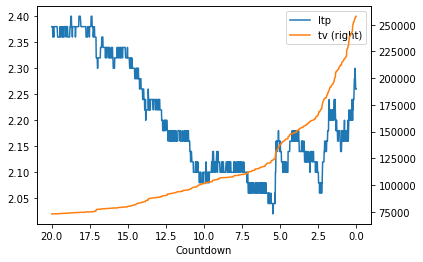

In [17]:
ax = market_slice_df.plot('Countdown','ltp')
market_slice_df.plot('Countdown','tv', secondary_y=True, ax=ax)
plt.gca().invert_xaxis()


looking at the plot above the vast majority of the money is traded in the final few minutes before the off!  At a glance there also seems to be some correlation between market liquidity and movement in price.  It would appear in this case at least that while market lquidity is low the price comes in and then around 10 mins before the off and as more money comes into the market the price begins to drift.  It would be interesting to see if this is a recurring theme.

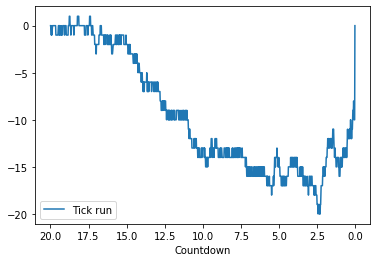

In [18]:
ax = market_slice_df.plot('Countdown','Tick run')
plt.gca().invert_xaxis()


I think it would be useful to try to quantify how the market moves so it can be directly compared with other markets.  I think maybe split the data into chunks of 5mins and 2 mins.  summarise the tv and tick run values for these chunks.  this data can be passed to another dataframe storing similar data fro lots of markets.  any discernable patterns can be grouped into categories.  these categories could be the start of formulating an alogorythm to predict how a market will move in real time. 

to do:<br>
    copy the df and split into equal chunks according to time.<br>
    summarise the data<br>
    def function for iterating of files in a folder and intergrate the code in box 2

i can split the data frame using the groupby function

In [58]:
segment_df_mean = market_slice_df.groupby(['Segment']).mean()
segment_df_mean

,Runner Id,Countdown,ltp,Tick,Tick run,tv
Segment,,,,,,
1,12146123.0,2.001909,2.161917,0.020833,-14.725000,188510.097208
2,12146123.0,5.986632,2.096793,-0.008439,-15.282700,123867.088312
3,12146123.0,9.993045,2.122581,-0.013825,-12.336406,100954.260876
4,12146123.0,13.917024,2.256338,-0.037559,-5.178404,84916.538685
5,12146123.0,17.920672,2.362769,-0.010256,-0.564103,75186.725385


In [59]:
segment_df_sum = market_slice_df.groupby(['Segment']).sum()
segment_df_sum

,Runner Id,Countdown,ltp,Tick,Tick run,tv
Segment,,,,,,
1,2915069520,480.458083,518.86,5,-3534,45242423.33
2,2878631151,1418.831883,496.94,-2,-3622,29356499.93
3,2635708691,2168.490783,460.60,-3,-2677,21907074.61
4,2587124199,2964.326183,480.60,-8,-1103,18087222.74
5,2368493985,3494.531117,460.74,-2,-110,14661411.45


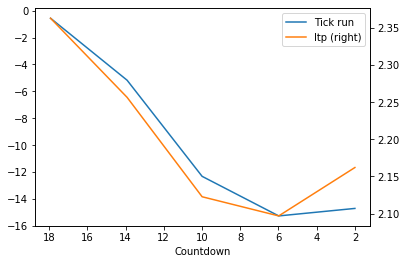

In [43]:
ax = segment_df_mean.plot('Countdown','Tick run')
segment_df_mean.plot('Countdown','ltp', secondary_y=True, ax=ax)
plt.gca().invert_xaxis()


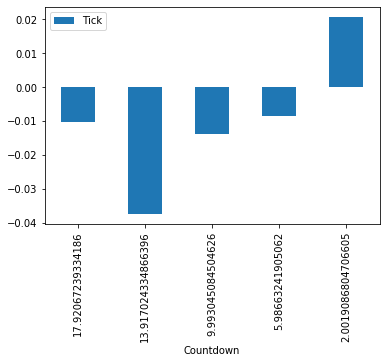

In [56]:
ax = segment_df_mean.plot('Countdown','Tick', kind = 'bar')

plt.gca().invert_xaxis()




In [52]:
segment_df.index.values

array([1, 2, 3, 4, 5], dtype=int64)

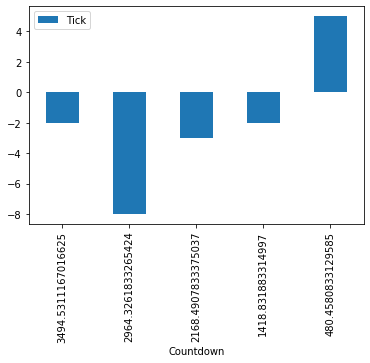

In [60]:
ax = segment_df_sum.plot('Countdown','Tick', kind = 'bar')

plt.gca().invert_xaxis()


Moving forward from here.  I think I need to build a standard set of summary statistics for each race and then from there I can try to discern correlations between market movements for each race<br><br>
raceID, runners, race type, tick range, tick min, tick max, front runner opeing price, tv by segment, tv, total ticks by segment, total ticks,<br><br>
These can lists can be added to a dict and converted to df for further analysis.